# Bike Sharing Project with Pytorch
## Udacity/ Facebook 2019

In this **project**, we'll build our first neural network and use it to predict daily bike rental ridership. 

In [1]:
#Importing modules
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

print(torch.__version__)

1.0.0


## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data.

In [2]:
data_path = 'hour.csv'

rides = pd.read_csv(data_path)
# Watch all columns
pd.options.display.max_columns = None

rides.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with our model.

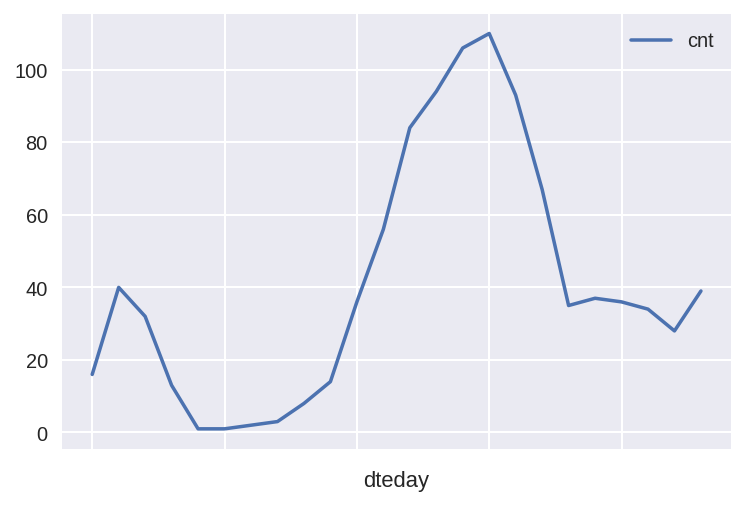

In [3]:
rides[:24].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [3]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
#data.head(10)
data[:10]


,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0000,3,13,16,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0000,8,32,40,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0000,5,27,32,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0000,3,10,13,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0000,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0.24,0.75,0.0896,0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0,0,0.22,0.80,0.0000,2,0,2,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,0,0,0.20,0.86,0.0000,1,2,3,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,0,0,0.24,0.75,0.0000,1,7,8,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0.32,0.76,0.0000,8,6,14,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [4]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

print(scaled_features)
data[:4]

{'casual': [35.67621842453536, 49.305030387053186], 'registered': [153.78686920996606, 151.35728591258317], 'cnt': [189.46308763450142, 181.38759909186527], 'temp': [0.4969871684216586, 0.19255612124972407], 'hum': [0.6272288394038822, 0.1929298340629125], 'windspeed': [0.1900976063064631, 0.12234022857279413]}


,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [5]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

###
features_list=[]

for row in features.iterrows():
    index, data = row
    features_list.append(data.tolist())

###
targets_list = []

for row in targets.iterrows():
    index, data = row
    targets_list.append(data.tolist())
    
###
test_features_list = []

for row in test_features.iterrows():
    index, data = row
    test_features_list.append(data.tolist())

###
test_targets_list = []

for row in test_targets.iterrows():
    index, data = row
    test_targets_list.append(data.tolist())
    

print(type(features))
print(features.shape, targets.shape)


<class 'pandas.core.frame.DataFrame'>
(16875, 56) (16875, 3)


### Making train, validation and test loaders

During the procedure we have to use Pytorch loaders for training, validation and testing. We will use the [**TensorDataset**](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) class to combine features and targets tensors. We will also use batch of 50 for training and validation and 500 for testing (almost the whole set for plotting the results later).

In [0]:
from torch.utils.data import TensorDataset, DataLoader

# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features_list[:-60*24], targets_list[:-60*24]
val_features, val_targets = features_list[-60*24:], targets_list[-60*24:]


train_features_tensors = torch.from_numpy(np.array(train_features))
train_targets_tensors = torch.from_numpy(np.array(train_targets))

val_features_tensors = torch.from_numpy(np.array(val_features))
val_targets_tensors = torch.from_numpy(np.array(val_targets))

test_features_tensors = torch.from_numpy(np.array(test_features_list))
test_targets_tensors = torch.from_numpy(np.array(test_targets_list))



########Dataset and Loaders
batch_sizes = 50
batch_size_test = 500

data_train = TensorDataset(train_features_tensors, train_targets_tensors)
train_loader = torch.utils.data.DataLoader(data_train, 
                                          batch_size=batch_sizes, shuffle=True)

data_val = TensorDataset(val_features_tensors, val_targets_tensors)
val_loader = torch.utils.data.DataLoader(data_val, 
                                          batch_size=batch_sizes, shuffle=True)

data_test = TensorDataset(test_features_tensors, test_targets_tensors)
test_loader = torch.utils.data.DataLoader(data_test, 
                                          batch_size=batch_size_test, shuffle=True)

### Checking some data from the loaders

We will print some data to verify how they are formulated

In [9]:
data_iter = iter(val_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([50, 56])
tensor([[ 1.0000,  0.0000,  0.0156,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000, -0.2960,  ...,  0.0000,  1.0000,  0.0000],
        [ 1.0000,  0.0000,  0.9504,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 1.0000,  0.0000, -1.2307,  ...,  0.0000,  1.0000,  0.0000],
        [ 1.0000,  0.0000, -0.1921,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000,  0.1195,  ...,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64)

torch.Size([50, 3])
tensor([[ 0.7968, -0.1354,  0.9990],
        [ 2.4949,  0.8178,  2.7234],
        [ 0.8630,  0.8178,  0.7678],
        [ 0.9347,  1.3655,  0.6753],
        [-0.7027, -0.6627, -0.6262],
        [ 3.0021, -0.3179,  3.7013],
        [-0.0411,  1.3249, -0.4809],
        [-0.0632, -0.1760, -0.0184],
        [ 0.1187, -0.6425,  0.3516],
        [-1.0225, -0.6830, -1.0028],
        [ 0.2400, -0.0746,  0.3119],
        [-0.9949, -0.6830, -0.9698],
        [ 0.9677,  0.6962,  0.9330],
        [ 2.153

### We make a simple RNN

We define input size, output size, hidden dimensions and hidden layers. 

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim
        self.n_layers = n_layers

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)

        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden

## We initialize the RNN

We define the parameters here. The input size is 56 as we saw the features.shape above. The output size is 3 as the targets.shape above. 
#### Choose the number of hidden nodes
   In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be. (A fully optimized model could have weights of zero, after all.) However, the more hidden nodes you have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.
   You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose. You'll generally find that the best number of hidden nodes to use ends up being between the number of input and output nodes.

In [8]:
input_size=56 
output_size=3
hidden_dim=4
n_layers=1

# instantiate an RNN
net = RNN(input_size, output_size, hidden_dim, n_layers)
print(net)

RNN(
  (rnn): RNN(56, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=3, bias=True)
)


### Connect to google drive

In [0]:
#Connect with drive


from google.colab import drive
drive.mount('/content/drive')

### MSELoss for criterion

We choose MSELoss for finding the error between the outputs and the targets ([loss-functions](https://pytorch.org/docs/stable/nn.html#loss-functions))
Also [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) for optimizer as it is prefered for RNNs



In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001) 

In [13]:
epochs = 40 # 30 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100

losses = {'train':[], 'validation':[]}
valid_loss_min = np.Inf

## Casts all floating point parameters and buffers to double datatype.
net.double()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = None

    # batch loop
    for batch_i, (inputs, labels) in enumerate(train_loader, 1):
        # move model to GPU, if available
        train_on_gpu = torch.cuda.is_available()
        if(train_on_gpu):
            net.cuda()
        net.train()    
        # make sure you iterate over completely full batches, only
        n_batches = len(train_loader.dataset)//50
        if(batch_i > n_batches):
            break            
            
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs.unsqueeze(1), h)

        h = h.data
        # calculate the loss and perform backprop       
        train_loss = criterion(output, labels)
        
        losses['train'].append(train_loss.item())

        train_loss.backward()
        
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            h = None
            val_losses = []
            net.eval()
            for inputs, labels in val_loader:

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs.unsqueeze(1), h)
                
                val_loss = criterion(output, labels)
                
                losses['validation'].append(val_loss.item())

                val_losses.append(val_loss.item())
                
                #save checkpoint
                net.cpu()
                
                checkpoint = {'model': net,                 
                 'state_dict': net.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict
                 }
                if val_loss <= valid_loss_min:
                    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    valid_loss_min,
                    val_loss))
                    torch.save(checkpoint, 'drive/My Drive/Colab Notebooks/colabArchives/model_soloupis_bikeShare_PR1.pt')
                    valid_loss_min = val_loss
                 
                net.cuda()
                net.train()
           
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(train_loss),
                  "Val Loss: {:.6f}".format(val_loss))

Validation loss decreased (inf --> 0.880430).  Saving model ...


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Validation loss decreased (0.880430 --> 0.594699).  Saving model ...
Validation loss decreased (0.594699 --> 0.583875).  Saving model ...
Epoch: 1/40... Step: 100... Loss: 0.453868... Val Loss: 0.901149
Validation loss decreased (0.583875 --> 0.536375).  Saving model ...
Epoch: 1/40... Step: 200... Loss: 0.980666... Val Loss: 1.335364
Epoch: 1/40... Step: 300... Loss: 0.508078... Val Loss: 1.507574
Validation loss decreased (0.536375 --> 0.460518).  Saving model ...
Validation loss decreased (0.460518 --> 0.428616).  Saving model ...
Epoch: 2/40... Step: 400... Loss: 0.332286... Val Loss: 0.617533
Validation loss decreased (0.428616 --> 0.387204).  Saving model ...
Epoch: 2/40... Step: 500... Loss: 0.884363... Val Loss: 0.435287
Validation loss decreased (0.387204 --> 0.277836).  Saving model ...
Epoch: 2/40... Step: 600... Loss: 0.282515... Val Loss: 0.342951
Epoch: 3/40... Step: 700... Loss: 0.539862... Val Loss: 0.501315
Validation loss decreased (0.277836 --> 0.243014).  Saving mod

### Plot training and validation losses

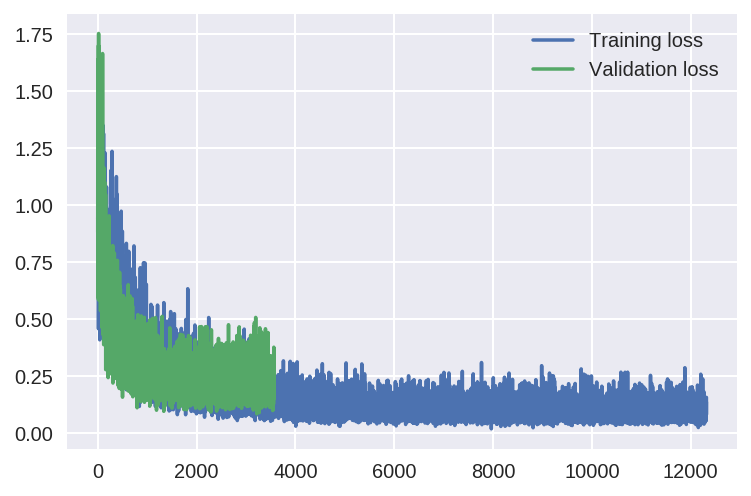

In [14]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

# If you don't want to train continue with below code

Load the dictionary to model and continue with plotting results

### Load dictionary to network

In [0]:
state_dict = torch.load('drive/My Drive/Colab Notebooks/colabArchives/model_soloupis_bikeShare_PR1.pt')
net.load_state_dict(state_dict['state_dict'])

###  Get test data loss

In [16]:

test_acc_list = []

test_losses = [] # track loss

# init hidden state
h = None

net.eval()
### We move to cpu so to use later output for plotting
net.cpu()
net.double()
for batch_i, (inputs, labels) in enumerate(test_loader, 1):

    # make sure you iterate over completely full batches, only
    n_batches = len(test_loader.dataset)//batch_size_test
    #print(n_batches)
    if(batch_i > n_batches):
        break
    
    print(batch_i)

    ## pass inputs through net
    output, test_h = net(inputs.unsqueeze(1), h)
    ##take a look at first output and label
    print("OUTPUT    ",output[0,:])
    print("LABEL    ",labels[0,:])
    
    ### We don't update weights at testing  
    
    # calculate the loss   
    test_loss = criterion(output, labels)
    test_losses.append(test_loss.item())
    print("TEST LOSSES : {}".format(test_losses))

1
OUTPUT     tensor([0.5003, 1.1485, 0.2281], dtype=torch.float64, grad_fn=<SliceBackward>)
LABEL     tensor([0.4550, 0.0877, 0.5167], dtype=torch.float64)
TEST LOSSES : [0.22667175532048578]


### Plot real data and predictions

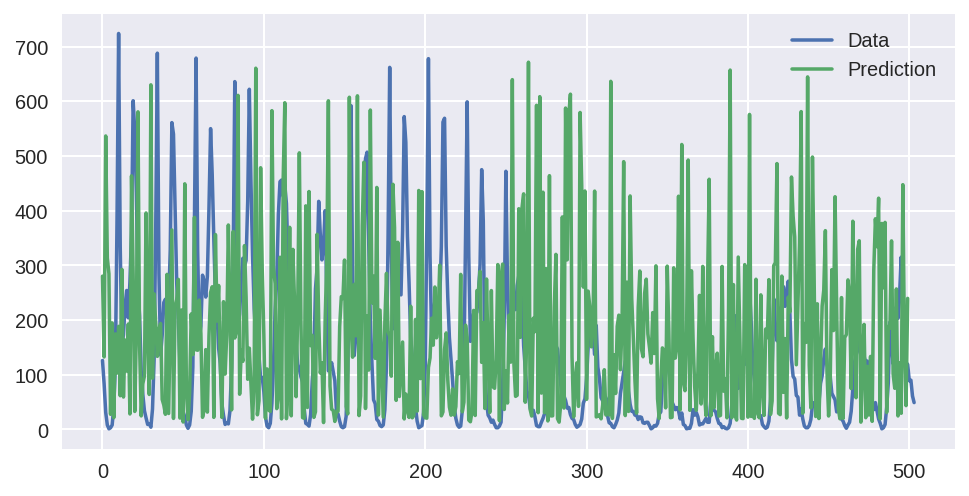

In [17]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
##plot real data
ax.plot((test_targets['cnt']*std + mean).values, label='Data')

##make tensor to numpy
output = output.detach().numpy()
## we get the first values of the output as these are the 'cnt' predictions
ax.plot(output[:][:,:1]*std + mean, label='Prediction')

plt.legend()

## IF YOU WANT TO START FROM THE BEGGINING USE BELOW CODE

In [0]:

!kill -9 -1